## Natural Language Processing 
## ------ Next Argument Prediction ------

# Clone the Project from Github repo

In [1]:
!git clone https://github.com/Sami-Osman/NAP.git

Cloning into 'NAP'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 390 (delta 3), reused 20 (delta 1), pack-reused 365
Receiving objects: 100% (390/390), 58.39 MiB | 16.14 MiB/s, done.
Resolving deltas: 100% (20/20), done.


# Install Transformers

In [3]:
!pip install transformers==3.1.0 -q

     |████████████████████████████████| 884 kB 30.0 MB/s 
     |████████████████████████████████| 1.3 MB 47.7 MB/s 
     |████████████████████████████████| 3.0 MB 56.8 MB/s 
     |████████████████████████████████| 880 kB 60.6 MB/s 


# Imports:

In [5]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW, get_linear_schedule_with_warmup
import torch.nn as nn
import os
import numpy as np
import torch

# Set working directory to the downloaded project folder

In [8]:
%cd /content/NAP/
working_dir = os.getcwd()

/content/NAP


# ! LETS GET STARTED !

# Dataset Processing

## Train Dataset:
### README.txt FILE HELPS TO UNDERSTAND HOW DATASETS ARE CREATED

In [9]:
# Kialo_GeneralDF class is defined in the file Kialo_GeneralDF.py (from Kialo text file to general data frame)
# GeneralDF_SentPairDF class is defined in the file GeneralDF_SentPairDF.py (generates argument pair dataset from general data frame .pkl file)
import Kialo_GeneralDF, GeneralDF_SentPairDF
#Training dataset:
trainData = Kialo_GeneralDF.main(working_dir + "/dataset/train", "trainData")
train_pair = GeneralDF_SentPairDF.main(working_dir + "/dataframe/trainData.pkl", "trainPair")

UPLOADING DATASET FROM FOLDER.........
	 Argument Pool Count 
	 trainData  size:  56877

trainPair size:  80754
	 0 => [YES NEXT ARGUMENT] 1 => [NOT NEXT ARGUMENT]
1    40378
0    40376
Name: label, dtype: int64


## Validation Dataset

In [10]:
# Validation dataset
validationdData = Kialo_GeneralDF.main(working_dir + "/dataset/validation", "validationData")
validation_pair = GeneralDF_SentPairDF.main(working_dir + "/dataframe/validationData.pkl", "validationPair")

UPLOADING DATASET FROM FOLDER.........
	 Argument Pool Count 
	 validationData  size:  16049

validationPair size:  22810
	 0 => [YES NEXT ARGUMENT] 1 => [NOT NEXT ARGUMENT]
0    11406
1    11404
Name: label, dtype: int64


## I Run this cell if I don't need to generate new dataset. Simply use the Dataset which was already generated from previous run time.

In [11]:
# run this cell if you want to access the sentence pair dataset already generated
folder = os.path.join(os.getcwd() , "dataframe")
path = os.path.join(folder, "trainPair.pkl")
Data = pd.read_pickle(path)
train_pair = Data.drop(['index', 'position1', 'position2'], axis = 1)
print('Train dataset size: ', len(train_pair))

path = os.path.join(folder, "validationPair.pkl")
Data = pd.read_pickle(path)
validation_pair = Data.drop(['index', 'position1', 'position2'], axis = 1)
print('validation dataset size: ', len(validation_pair))

Train dataset size:  80754
validation dataset size:  22810


## There are three different versions of Models:
▶ version 0 BaseModel 
▶ version 1 Basemodel+LSTM
▶ version 2 Basemodel+GRU


In [12]:
# Config.py file contains Variables used to configure the Network.
from Config import Config

""" Model versions [0: PairClrBaseModel,
                    1: PairClassifierPLSTM,
                    2: PairClassifierPGRU
                   ] 
    and CustomDataset are defined in the Dataset_Model.py file."""
from Dataset_Model import CustomDataset, PairClrBaseModel, PairClassifierPLSTM, PairClassifierPGRU

# Utility.py file contains several function used as checkpoint, set seed, show graphs etc..
from Utility import checkpoint 

# Train_Res.py contains the training loops and validation class definitions
from train import Train_Res 

## Custom Dataset and Data Loaders:

In [13]:
checkpoint.set_seed(1)
# Creating instances of training and validation Custom data set
print("Reading training data...")
train_set = CustomDataset(train_pair, Config.maxlen,Config.with_labels, Config.bert_model)
print("Reading validation data...")
val_set = CustomDataset(validation_pair, Config.maxlen, Config.with_labels, Config.bert_model)


# Creating instances of training and validation dataloaders
train_loader = DataLoader(train_set, batch_size=Config.bs, num_workers=5, shuffle=True)
val_loader = DataLoader(val_set, batch_size=Config.bs, num_workers=5)

Reading training data...


Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

Reading validation data...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## TRAINING

In [14]:
#net = PairClrBaseModel(Config.bert_model, Config.freeze_bert) # uncomment to train the base model version 0 of the project
#net = PairClassifierPLSTM(Config.bert_model, Config.freeze_bert) # uncomment to train the base+LSTM model version 1 of the project
net = PairClassifierPGRU(Config.bert_model, Config.freeze_bert) # uncomment to train the base+GRU model version 2 of the project
net.to(Config.device)
      
opti = AdamW(net.parameters(), lr=Config.lr, weight_decay=1e-2)
lr_scheduler = checkpoint.get_my_lr_scheduler(opti, train_loader, Config.epochs)
Get_result = Train_Res(Config.device, Config.bert_model) # creating an instance of Train_Res class for training the network
train_losses, val_losses, train_acc, val_acc= Get_result.train_bert(net, Config.criterion, opti, Config.lr, train_loader, val_loader, Config.epochs, lr_scheduler, Config.bert_version)


Downloading:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

 33%|███▎      | 1683/5048 [02:26<04:31, 12.39it/s]


Iteration 1682/5048 of epoch 1 complete. Loss : 0.3737538158893585 
Training Accuracy : 81.25 %


 67%|██████▋   | 3365/5048 [04:52<02:30, 11.17it/s]


Iteration 3364/5048 of epoch 1 complete. Loss : 0.36266887187957764 
Training Accuracy : 68.75 %


100%|██████████| 5048/5048 [07:14<00:00, 13.31it/s]


Iteration 5046/5048 of epoch 1 complete. Loss : 0.4036363661289215 
Training Accuracy : 68.75 %


  0%|          | 0/1426 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 1426/1426 [03:28<00:00,  6.84it/s]


Epoch 1 complete! Validation Loss : 0.4869380330909853
Validation Accuracy : 74.8921809256662 %
Best validation loss improved from inf to 0.4869380330909853
The model has been saved in models/v_2_albert-base-v2.pth


  0%|          | 0/5048 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
 33%|███▎      | 1683/5048 [02:18<04:30, 12.43it/s]


Iteration 1682/5048 of epoch 2 complete. Loss : 0.5108574628829956 
Training Accuracy : 81.25 %


 67%|██████▋   | 3365/5048 [04:34<02:15, 12.44it/s]


Iteration 3364/5048 of epoch 2 complete. Loss : 0.50093674659729 
Training Accuracy : 87.5 %


100%|██████████| 5048/5048 [06:56<00:00, 13.45it/s]


Iteration 5046/5048 of epoch 2 complete. Loss : 0.7129485607147217 
Training Accuracy : 56.25 %


  0%|          | 0/1426 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 1426/1426 [03:29<00:00,  6.81it/s]


Epoch 2 complete! Validation Loss : 0.47865749360552007
Validation Accuracy : 73.80960729312763 %
Best validation loss improved from 0.4869380330909853 to 0.47865749360552007
The model has been saved in models/v_2_albert-base-v2.pth


  0%|          | 0/5048 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
 33%|███▎      | 1683/5048 [02:25<04:30, 12.42it/s]


Iteration 1682/5048 of epoch 3 complete. Loss : 0.3473139703273773 
Training Accuracy : 75.0 %


 67%|██████▋   | 3366/5048 [04:47<02:15, 12.42it/s]


Iteration 3364/5048 of epoch 3 complete. Loss : 0.4576086401939392 
Training Accuracy : 62.5 %


100%|█████████▉| 5047/5048 [07:09<00:00, 11.47it/s]


Iteration 5046/5048 of epoch 3 complete. Loss : 0.45753663778305054 
Training Accuracy : 81.25 %


  0%|          | 0/1426 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 1426/1426 [03:30<00:00,  6.76it/s]


Epoch 3 complete! Validation Loss : 0.4729963585755267
Validation Accuracy : 76.07556100981768 %
Best validation loss improved from 0.47865749360552007 to 0.4729963585755267
The model has been saved in models/v_2_albert-base-v2.pth


  0%|          | 0/5048 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
 33%|███▎      | 1683/5048 [02:22<04:34, 12.24it/s]


Iteration 1682/5048 of epoch 4 complete. Loss : 0.3837625980377197 
Training Accuracy : 81.25 %


 67%|██████▋   | 3366/5048 [04:46<02:15, 12.41it/s]


Iteration 3364/5048 of epoch 4 complete. Loss : 0.5022485852241516 
Training Accuracy : 62.5 %


100%|██████████| 5048/5048 [07:04<00:00, 11.91it/s]


Iteration 5046/5048 of epoch 4 complete. Loss : 0.5738451480865479 
Training Accuracy : 68.75 %


  0%|          | 0/1426 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 1426/1426 [03:28<00:00,  6.83it/s]


Epoch 4 complete! Validation Loss : 0.4716493295085046
Validation Accuracy : 76.44810659186535 %
Best validation loss improved from 0.4729963585755267 to 0.4716493295085046
The model has been saved in models/v_2_albert-base-v2.pth


  0%|          | 0/5048 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
 33%|███▎      | 1683/5048 [02:19<04:40, 12.00it/s]


Iteration 1682/5048 of epoch 5 complete. Loss : 0.5596981644630432 
Training Accuracy : 75.0 %


 67%|██████▋   | 3366/5048 [04:38<02:18, 12.15it/s]


Iteration 3364/5048 of epoch 5 complete. Loss : 0.4188104569911957 
Training Accuracy : 87.5 %


100%|█████████▉| 5047/5048 [06:59<00:00, 12.44it/s]


Iteration 5046/5048 of epoch 5 complete. Loss : 0.2792142629623413 
Training Accuracy : 87.5 %


  0%|          | 0/1426 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 1426/1426 [03:28<00:00,  6.84it/s]


Epoch 5 complete! Validation Loss : 0.47062732852984945
Validation Accuracy : 76.05364656381487 %
Best validation loss improved from 0.4716493295085046 to 0.47062732852984945
The model has been saved in models/v_2_albert-base-v2.pth


## Training Output Graphs:

Out put Graphs for: 
	 Bert Model:  albert-base-v2
	 Model Version:  2


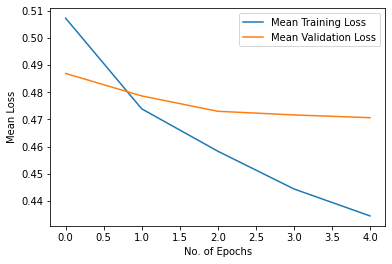

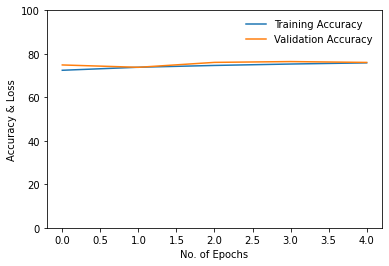

In [15]:
print("Out put Graphs for: ")
print("\t Bert Model: ", Config.bert_model)
print("\t Model Version: ", Config.bert_version)
#plotting
checkpoint.show_loss(train_losses, val_losses)
checkpoint.show_accuracy(train_acc, val_acc)

# Test Phase

## Preparing Test Dataset

In [16]:
# Generate The test Dataset from Scratch
testData = Kialo_GeneralDF.main(working_dir + "/dataset/test", "testData")
test_pair = GeneralDF_SentPairDF.main(working_dir + "/dataframe/testData.pkl", "testPair")

UPLOADING DATASET FROM FOLDER.........
	 Argument Pool Count 
	 testData  size:  7269

testPair size:  10264
	 0 => [YES NEXT ARGUMENT] 1 => [NOT NEXT ARGUMENT]
1    5135
0    5129
Name: label, dtype: int64


### Already prepared Test Dataset

In [17]:
path = os.path.join(folder, "testPair.pkl")
Data = pd.read_pickle(path)
test_pair = Data.drop(['index', 'position1', 'position2'], axis = 1)
print('Test dataset size: ', len(test_pair))

Test dataset size:  10264


## Setting output directory and saved Model weights

In [18]:
print("Creation of the results' folder to store the output prediction of the models")
!mkdir results

path_to_output_file = working_dir + '/results/v_{}_{}_output.txt'.format(Config.bert_version, Config.bert_model)
checkpoint_fpath = working_dir + '/models/v_{}_{}.pth'.format(Config.bert_version, Config.bert_model)  


Creation of the results' folder to store the output prediction of the models
mkdir: cannot create directory ‘results’: File exists


## Create a fresh 
-- CustomDataset
-- Dataloader
-- Model.

In [19]:
## Create instance of Dataloader for Test dataset.
print("Reading test data...")
test_set = CustomDataset(test_pair, Config.maxlen, Config.with_labels, Config.bert_model)
test_loader = DataLoader(test_set, batch_size=Config.bs, num_workers=5)

# Create instance of prefered model version with fresh learning param/weights
# Un comment the version of the model version you want to use.

#model_test = PairClrBaseModel(Config.bert_model, freeze_bert=Config.freeze_bert) # base version 0
#model_test = PairClassifierPLSTM(Config.bert_model, freeze_bert=Config.freeze_bert) # version 1 [LSTM]
model_test = PairClassifierPGRU(Config.bert_model, freeze_bert=Config.freeze_bert) # version 2 [GRU]

Reading test data...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Loading 
###--Weights from saved best model status.
###--Model to device.

In [20]:
model_test= checkpoint.load(checkpoint_fpath, model_test, Config.criterion) # Loading the weights of the model
model_test.to(Config.device) # "Loading the model to device[cuda/CPU]

PairClassifierPGRU(
  (bert_layer): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=Tru

## Use the model to get Predictions

In [21]:
import output # I defined this file to use the new loaded model to predict the output independently.
True_value = test_pair['label']
print("Predicting on test data...")
# set the with_labels parameter to False if your want to get predictions on a dataset without labels
pred_value = output.test_phase(net=model_test, device=Config.device, dataloader=test_loader, with_labels=Config.with_labels,
                result_file=path_to_output_file)

Predicting on test data...


100%|██████████| 642/642 [01:35<00:00,  6.70it/s]


Predictions are available in : /content/NAP/results/v_2_albert-base-v2_output.txt


## Analysis on the output generated from the Test Dataset 

# Confusion Matrix

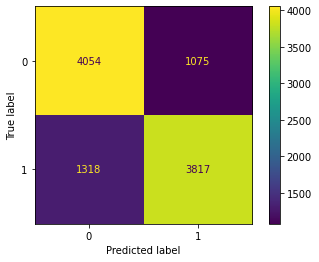

In [22]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(True_value, pred_value, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

# Classification report

In [23]:
from sklearn.metrics import classification_report, f1_score
target_names = ['IS NEXT ARGUMENT', 'IS NOT NEXT ARGUMENT']
print(classification_report(True_value, pred_value, target_names=target_names))

                      precision    recall  f1-score   support

    IS NEXT ARGUMENT       0.75      0.79      0.77      5129
IS NOT NEXT ARGUMENT       0.78      0.74      0.76      5135

            accuracy                           0.77     10264
           macro avg       0.77      0.77      0.77     10264
        weighted avg       0.77      0.77      0.77     10264

